In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../src')

import pandas as pd
pd.set_option('display.max_rows', 100)

import seaborn as sns
sns.set_theme(context='talk', style="darkgrid", palette='dark', font='sans-serif')


import cudf
import xgboost
import lightgbm
from pathlib import Path

from sales_project.utils import read_yaml
from sales_project.evaluations import evaluate
from sales_project.plotters import linear_plot
from sales_project.feature_selection import PermutationImportance

In [2]:
target = 'item_cnt_month'
timestamp_col = 'date_block_num'
min_timestamp = 8

df = pd.read_parquet("../data/artifacts/df3.parquet").query(f"{timestamp_col} >= {min_timestamp}")
#df_submission = pd.read_parquet("../data/artifacts/df_submission.parquet")


features = list(df.columns)
features.remove(target)
features.remove(timestamp_col)
features.remove('shop_id')
features.remove('item_id')

df[target] = df[target].clip(0, 20)

In [3]:
#df_test = df[df['date_block_num'] == 33]
df_val = df.query('date_block_num == 32')
df = df.query('date_block_num < 32')

# XGBoost

In [4]:
params = read_yaml(Path(f"../params/default/xgboost.yaml"))
model = xgboost.XGBRegressor(**params)
model.fit(df[features], df[target])

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.5, colsample_bynode=0.5, colsample_bytree=0.5,
             device='cpu', early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=1, learning_rate=0.05,
             max_bin=255, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=1023,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=16, ...)

In [5]:
df_val['pred'] = model.predict(df_val[features])
evaluate(df_val, target, 'pred')

{'MAE': 0.2902042865753174,
 'MSE': 0.5037281513214111,
 'RMSE': 0.7097380864244296,
 'R2': 0.4932183027267456,
 'MAPE': 635034201489408.0,
 'SMAPE': 184.69891548156738}

In [6]:
permutator = PermutationImportance(
    model=model,
    features=features,
    target=target,
    n_permutations=20,
    is_gpu_accelerated=False,
)

In [8]:
importances = permutator.evaluate_features(
    features_to_permutate=features, 
    df=df_val,
)

Evaluating importance of features:   0%|          | 0/165 [00:00<?, ?it/s]

In [10]:
importances_rmse = importances.groupby(['feature']).mean()[['RMSE']].sort_values(by='RMSE', ascending=False).reset_index()
importances_rmse['fearure_id'] = list(range(len(importances_rmse)))
importances_rmse

,feature,RMSE,fearure_id
0,item_id.item_cnt_month.mean.ewm.mean,0.002421,0
1,item_revenue_month.lag.1,0.002208,1
2,shop_emb_group_id.item_id.item_cnt_month.mean....,0.001862,2
3,item_age.new_item.item_cnt_month.mean.expandin...,0.000975,3
4,item_cnt_day_avg.lag.3,0.000948,4
...,...,...,...
160,shop_id.item_category_id.item_cnt_month.mean.r...,-0.005154,160
161,item_category_id.item_age.item_cnt_month.mean....,-0.005760,161
162,shop_id.item_id.item_cnt_month.mean.rolling.me...,-0.008739,162
163,item_id.item_cnt_day_avg.mean.lag.1,-0.011792,163


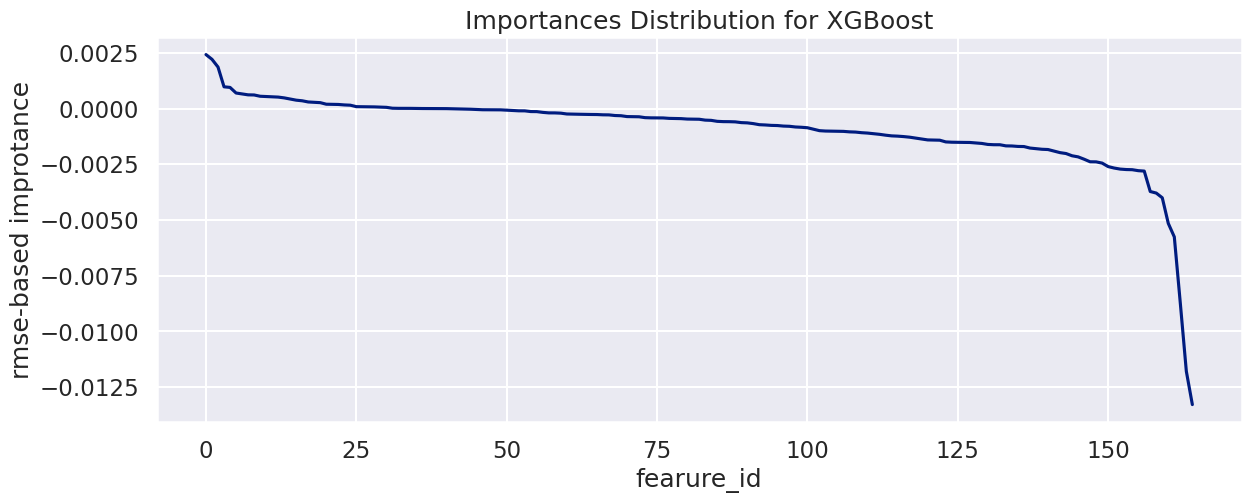

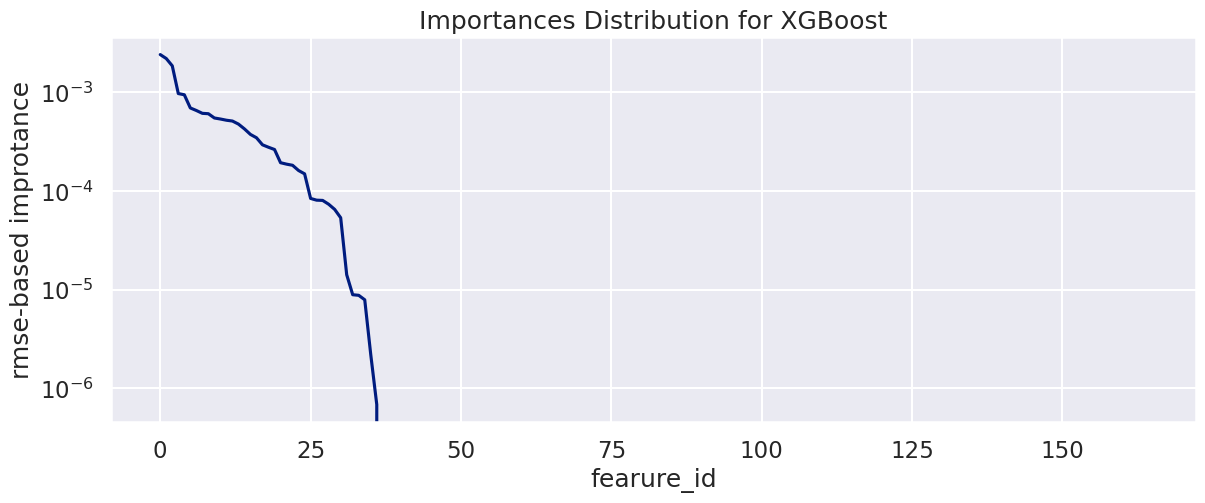

In [11]:
linear_plot(
    data=importances_rmse, 
    x='fearure_id', 
    y='RMSE', 
    title='Importances Distribution for XGBoost',
    y_label='rmse-based improtance'
)
linear_plot(
    data=importances_rmse, 
    x='fearure_id', 
    y='RMSE', 
    title='Importances Distribution for XGBoost',
    y_label='rmse-based improtance',
    y_scale='log'
)

# LightGBM

In [4]:
params = read_yaml(Path(f"../params/default/ligthgbm.yaml"))
model = lightgbm.LGBMRegressor(**params)
model.fit(df[features], df[target])

LGBMRegressor(bagging_fraction=0.6, bagging_freq=5, cat_smooth=10,
              feature_fraction=0.6, learning_rate=0.01, max_bin=255,
              max_depth=8, n_estimators=1000, num_iterations=100,
              num_leaves=255, num_threads=10, random_state=42, verbosity=-1)

In [6]:
df_val['pred'] = model.predict(df_val[features])
evaluate(df_val, target, 'pred')

{'MAE': 0.3418223865973846,
 'MSE': 0.5950290901018125,
 'RMSE': 0.771381287108919,
 'R2': 0.4013639279316963,
 'MAPE': 804696262072743.9,
 'SMAPE': 185.52885180795354}

In [7]:
permutator = PermutationImportance(
    model=model,
    features=features,
    target=target,
    n_permutations=20,
    is_gpu_accelerated=False,
)

In [8]:
importances = permutator.evaluate_features(
    features_to_permutate=features, 
    df=df_val,
)

Evaluating importance of features:   0%|          | 0/165 [00:00<?, ?it/s]

In [9]:
importances_rmse = importances.groupby(['feature']).mean()[['RMSE']].sort_values(by='RMSE', ascending=False).reset_index()
importances_rmse['fearure_id'] = list(range(len(importances_rmse)))
importances_rmse

,feature,RMSE,fearure_id
0,item_id.item_cnt_month.mean.ewm.mean,0.000354,0
1,item_name_group.item_cnt_month.mean.ewm.mean,0.000330,1
2,category_emb_group_id.item_cnt_month.mean.expa...,0.000297,2
3,item_name_group.item_cnt_month.mean.delta.1.lag.1,0.000216,3
4,platform_id.item_cnt_month.mean.lag.1,0.000211,4
...,...,...,...
160,item_id.item_cnt_day_avg.mean.lag.1,-0.011543,160
161,shop_id.item_category_id.item_cnt_month.mean.r...,-0.014352,161
162,item_cnt_month.lag.1,-0.017344,162
163,shop_id.item_id.item_cnt_month.mean.rolling.me...,-0.029460,163


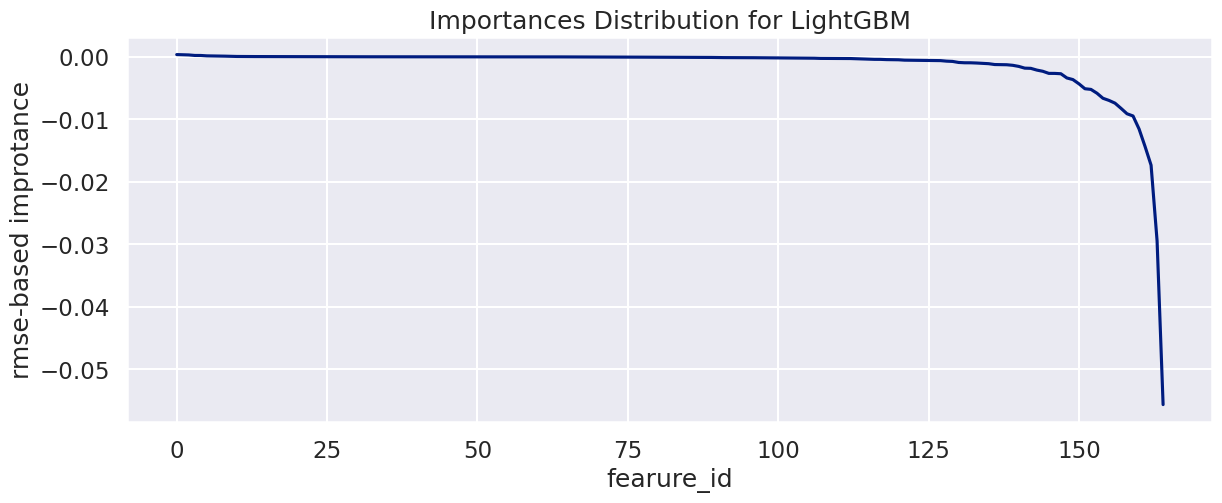

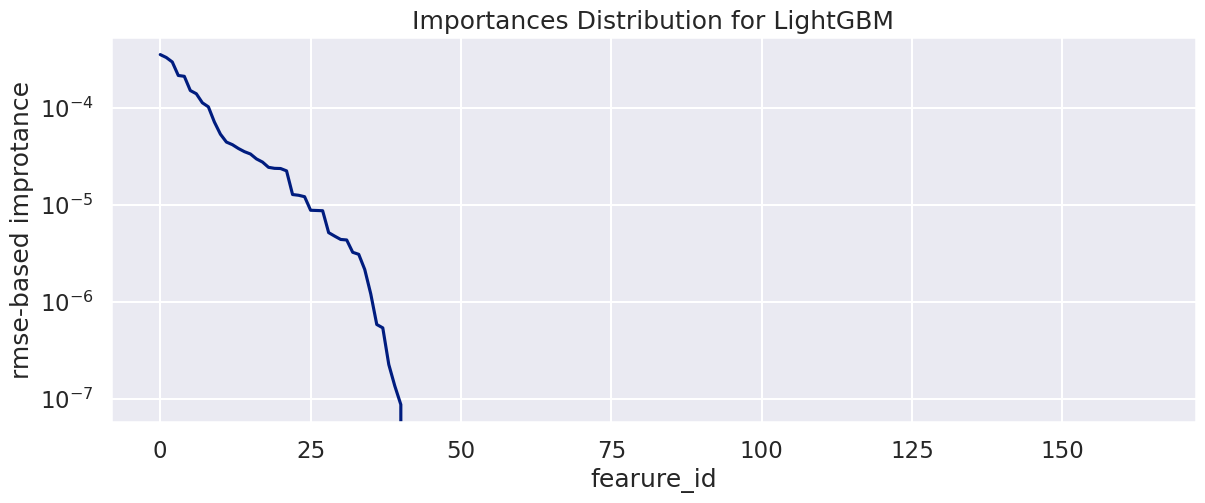

In [11]:
linear_plot(
    data=importances_rmse, 
    x='fearure_id', 
    y='RMSE', 
    title='Importances Distribution for LightGBM',
    y_label='rmse-based improtance'
)
linear_plot(
    data=importances_rmse, 
    x='fearure_id', 
    y='RMSE', 
    title='Importances Distribution for LightGBM',
    y_label='rmse-based improtance',
    y_scale='log'
)